# Introduction

Need to speed up the calculation so moving to python


### Functions

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from scipy.integrate import odeint
from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

def rhs(z,t,J,K,n,nu,omega):
    """
    z0 = [x0,theta0], where x0[i], y0[i], theta0[i] gives the x[t=0], y[y=0], theta[t=0] of the i-th swarmalator
    t = time parameter (need this here to pass to python's odeint function)
    J = float
    K = float
    n = number of swarmalators
    omega = [omega1, omega2, ..., ] natural frequencies of swarmaltors
    """
    
    #Instantiate -- set up 
    x = z[0:n]
    theta = z[n:2*n]
    
    # Set up as a numpy.array to make the computation faster
    xd = x[:, np.newaxis] - x
    theta_d = theta[:, np.newaxis] - theta
    x_rhs = -J*np.nan_to_num(np.sin(xd)*np.cos(theta_d) ) 
    theta_rhs = -K*np.nan_to_num( np.sin(theta_d)*np.cos(xd) ) 
    
    # The actual R.H.S.
    x_next = nu + np.nan_to_num((1/float(n))*np.sum((1-np.eye(xd.shape[0]))*x_rhs, axis=1))
    theta_next = omega + np.nan_to_num(omega +  (1/float(n))*np.sum((1-np.eye(xd.shape[0]))*theta_rhs, axis=1))
                                              
    return np.concatenate((x_next, theta_next))


def unpack(sols,n):
    """ I store the positions and phases of each swarmalator as a 3d vector z.
        Then the state vector for the systems is z[t][n]. This functions
        "unpacks" z[t][n] into x[t][n], y[t][n], theta[t][n]
    """

    T = len(sols)     #num timesteps
    x = np.array(np.zeros((T,n)))
    theta = np.array(np.zeros((T,n)))
    for t in range(T):
        x[t] = sols[t, 0:n]
        theta[t] = sols[t, n:2*n]    
    return [x,theta]


def find_gamma(phi, transient_index=False):
    """ gamma = fraction of swarmalators exectuing full cycles """
    tolerance = 0.01
    gamma = 0.0
    for osc in range(phi.shape[1]):
        y = phi[:,osc]
        if transient_index == False:
            transient_index = int(0.5*len(y))
        temp = np.sin(y[transient_index:-1])
        temp = (max(temp) - min(temp)) / 2.0
        if temp > 1 - tolerance:
            gamma += 1.0
    return gamma / phi.shape[1]


def find_Ws(x, theta):
    """ Finds time series of order parameter W^+  = < e^{i*( phi_j + theta_j)} >_j -- see paper """
    numT, num_osc = x.shape
    W_plus, W_minus = 1j*np.zeros(numT), 1j*np.zeros(numT)
    for t in range(numT):
        W_plus[t] = np.sum(np.exp(1j*(x[t,:] + theta[t,:]))) / float(num_osc)
        W_minus[t] = np.sum(np.exp(1j*(x[t,:] - theta[t,:]))) / float(num_osc)
    return W_plus, W_minus


def scatter_t(x, theta,t):
    """ Make a scatter plot of swarmalators at time t in the (x,y) plane 
        where swarmalators are colored according to their phase
        
        x = np.array, x[t][i] = x-coord of i-th swarmalator at time t
        y = np.array, y[t][i] = y-coord of i-th swarmalator at time t
        
    """
    
    #fig = plt.figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(np.mod(x[t,:],2*np.pi) - np.pi, np.mod(theta[t,:],2*np.pi) -np.pi )
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-np.pi, np.pi])
    plt.xlabel('x', fontsize=14);plt.ylabel('theta', fontsize=14)
    
    
def plot_temp(t):
    """ Auxilaryl function for method above """
    scatter_t(x,theta,t)

/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:850: MatplotlibDeprecationWarning: 
The text.dvipnghack rcparam was deprecated in Matplotlib 2.1 and will be removed two minor releases later.
  version, name=key, obj_type="rcparam", alternative=alt_key)

Bad key "axes.color_cycle" on line 242 in
/Users/Kev/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Main

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<S+> = 0.04 
<S-> = 0.02 
gamma_x = 0.037 
gammx_theta = 0.006 


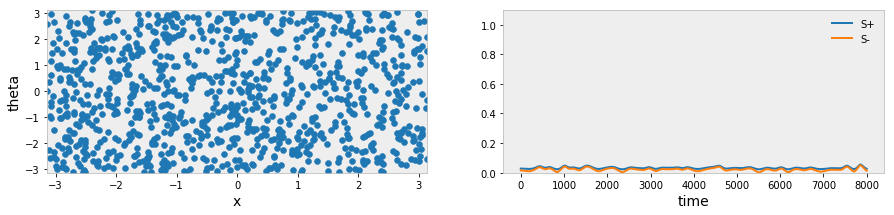

In [57]:
# Simulation parameters
J, K, delta, = 1.0, -1.0, 0.25
dt, T, n  = 0.25, 2000, 1000  # surprisingly, dt = 0.5 seems to work OK (for prelimiart)
np.random.seed(0)
#x0, theta0, = np.random.uniform(0,0.5*np.pi,n), np.random.uniform(0,0.5*np.pi,n)
x0, theta0 = np.random.uniform(0,2*np.pi,n), np.random.uniform(0,2*np.pi,n)
nu, omega = np.zeros(n), np.zeros(n)
#nu, omega = np.random.uniform(-delta,delta,n), np.random.uniform(-delta,delta,n)
#nu, omega =  np.linspace(-delta, delta, n), np.linspace(-delta, delta, n)
shuffle(nu);shuffle(omega)


z0 = [x0, theta0]
t = [dt*i for i in range(int(T/dt))]

# Do simulation
tic = time.clock()
z0 = np.array([x0, theta0])
z0 = z0.flatten()
sols = odeint(rhs, z0, t, args=(J,K,n,nu,omega))
x, theta = unpack(sols,n)

# Collect auxiliary info, like the order parameter gamma, and S
transient_index = int(0.9*len(x))
W_plus, W_minus = find_Ws(x, theta)
S_plus, S_minus = np.abs(W_plus), np.abs(W_minus)
S_plus, S_minus = np.mean(S_plus[transient_index:]), np.mean(S_minus[transient_index])
gamma_x = find_gamma(x, transient_index=transient_index)
gamma_theta = find_gamma(theta,transient_index=transient_index)

print(f'<S+> = {S_plus:.2f} ')
print(f'<S-> = {S_minus:.2f} ')
print(f'gamma_x = {gamma_x} ')
print(f'gammx_theta = {gamma_theta} ')


# Plot at end
fig, axes = plt.subplots(1,2, figsize=(15,3))
axes = axes.flatten()

ax, t = axes[0], -1
ax.scatter(np.mod(x[t,:],2*np.pi) - np.pi, np.mod(theta[t,:],2*np.pi) -np.pi )
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-np.pi, np.pi])
ax.set_xlabel('x', fontsize=14);ax.set_ylabel('theta', fontsize=14)

ax = axes[1]
ax.plot(np.abs(W_plus));
ax.plot(np.abs(W_minus));
ax.set_ylim([0,1.1]);ax.set_xlabel('time', fontsize=14);ax.legend(['S+','S-'],frameon=False);

#interact(plot_temp,t=(0,x.shape[0]-1,1))

In [43]:
interact(plot_temp,t=(0,x.shape[0]-1,1))

interactive(children=(IntSlider(value=499, description='t', max=999), Output()), _dom_classes=('widget-interac…

<function __main__.plot_temp(t)>

<Figure size 432x288 with 0 Axes>

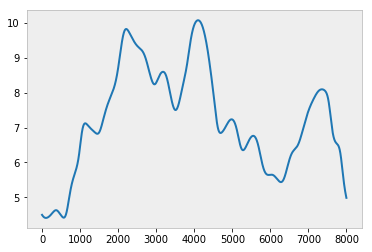

In [61]:
plt.plot(x[:,1])

### Strobe over $K$

1. Active phase wave
    - gamma = 1
    - 0 < S+ < 1
    - S- = 0
    
2. Partial sync

 - gamma < 1
 - 0 < S+ < 1
 - 0 < S- < 1

K = -1.00 done


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


K = -0.95 done
K = -0.90 done
K = -0.85 done
K = -0.80 done
K = -0.75 done
K = -0.70 done
K = -0.65 done
K = -0.60 done
K = -0.55 done
K = -0.50 done
K = -0.45 done
K = -0.40 done
K = -0.35 done
K = -0.30 done
K = -0.25 done
K = -0.20 done
K = -0.15 done
K = -0.10 done
K = -0.05 done
K = 0.00 done
K = 0.05 done
K = 0.10 done
K = 0.15 done
K = 0.20 done
K = 0.25 done
K = 0.30 done
K = 0.35 done
K = 0.40 done
K = 0.45 done
K = 0.50 done
K = 0.55 done
K = 0.60 done
K = 0.65 done
K = 0.70 done
K = 0.75 done
K = 0.80 done
K = 0.85 done
K = 0.90 done
K = 0.95 done
K = 1.00 done


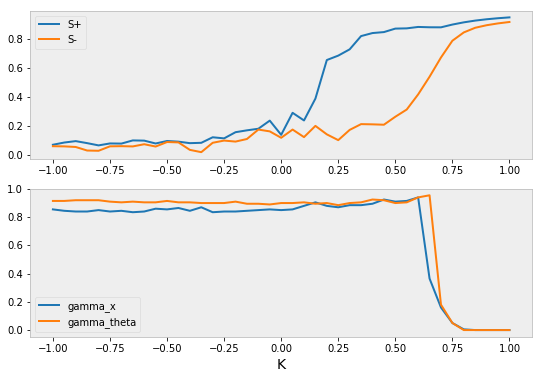

In [216]:
def solve(K):
    """ Solve and find order parameters for a given system """
    
    # Simulation parameters
    J, delta, = 1.0, 0.25
    dt, T, n  = 0.25, 200, 200 
    np.random.seed(0)
    x0, theta0, = np.random.uniform(0,0.5*np.pi,n), np.random.uniform(0,0.5*np.pi,n)
    nu, omega = np.zeros(n), np.zeros(n)
    nu, omega = np.random.uniform(-delta,delta,n), np.random.uniform(-delta,delta,n)
    
    
    z0 = [x0, theta0]
    t = [dt*i for i in range(int(T/dt))]

    # Do simulation
    tic = time.clock()
    z0 = np.array([x0, theta0])
    z0 = z0.flatten()
    sols = odeint(rhs, z0, t, args=(J,K,n,nu,omega))
    x, theta = unpack(sols,n)

    # Collect auxiliary info, like the order parameter gamma, and S
    gamma_x, gamma_theta = find_gamma(x), find_gamma(theta)
    W_plus, W_minus = find_Ws(x, theta)
    S_plus, S_minus = np.abs(W_plus), np.abs(W_minus)
    transient_index = int(0.9*len(x))
    S_plus, S_minus = np.mean(S_plus[transient_index:]), np.mean(S_minus[transient_index])
    
    # Reorder
    if S_plus < S_minus:
        S_plus, S_minus = S_minus, S_plus
        
    return S_plus, S_minus, gamma_x, gamma_theta

Sps, Sms, gamma_xs, gamma_thetas = [], [], [], []
Ks = np.linspace(-1,1,41)
for K in Ks:
    print(f'K = {K:.2f} done')
    S_plus, S_minus, gamma_x, gamma_theta = solve(K)
    Sps.append(S_plus);Sms.append(S_minus)
    gamma_xs.append(gamma_x);gamma_thetas.append(gamma_theta)
fig, axes = plt.subplots(2,1, figsize=(9,6))
axes = axes.flatten()
ax = axes[0]
ax.plot(Ks,Sps);ax.plot(Ks,Sms);ax.legend(['S+','S-']);
ax = axes[1]
ax.plot(Ks,gamma_xs);ax.plot(Ks,gamma_thetas);ax.set_xlabel('K',fontsize=14);
ax.legend(['gamma_x','gamma_theta']);

K = 0.50 done


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


K = 0.53 done
K = 0.55 done
K = 0.57 done
K = 0.60 done
K = 0.62 done
K = 0.65 done
K = 0.68 done
K = 0.70 done
K = 0.72 done
K = 0.75 done
K = 0.78 done
K = 0.80 done
K = 0.82 done
K = 0.85 done
K = 0.88 done
K = 0.90 done
K = 0.93 done
K = 0.95 done
K = 0.98 done
K = 1.00 done


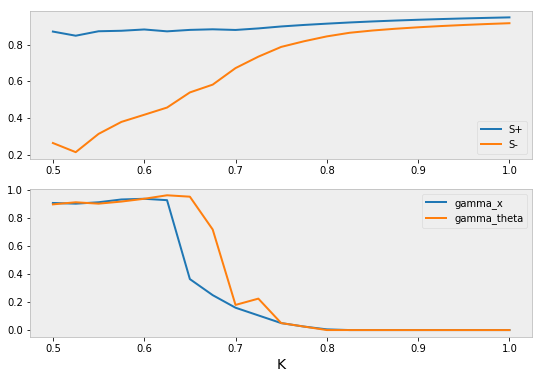

In [217]:
Sps, Sms, gamma_xs, gamma_thetas = [], [], [], []
Ks = np.linspace(0.5,1,21)
for K in Ks:
    print(f'K = {K:.2f} done')
    S_plus, S_minus, gamma_x, gamma_theta = solve(K)
    Sps.append(S_plus);Sms.append(S_minus)
    gamma_xs.append(gamma_x);gamma_thetas.append(gamma_theta)
fig, axes = plt.subplots(2,1, figsize=(9,6))
axes = axes.flatten()
ax = axes[0]
ax.plot(Ks,Sps);ax.plot(Ks,Sms);ax.legend(['S+','S-']);
ax = axes[1]
ax.plot(Ks,gamma_xs);ax.plot(Ks,gamma_thetas);ax.set_xlabel('K',fontsize=14);
ax.legend(['gamma_x','gamma_theta']);

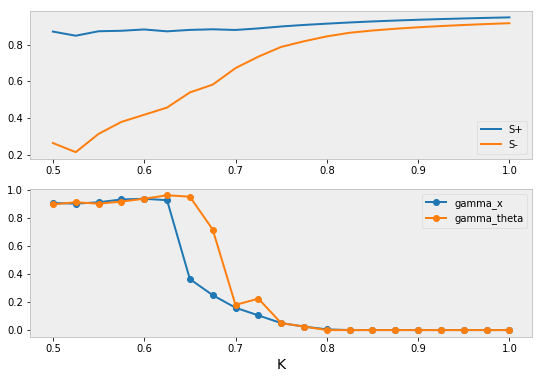

In [218]:
fig, axes = plt.subplots(2,1, figsize=(9,6))
axes = axes.flatten()
ax = axes[0]
ax.plot(Ks,Sps);ax.plot(Ks,Sms);ax.legend(['S+','S-']);
ax = axes[1]
ax.plot(Ks,gamma_xs,'-o');ax.plot(Ks,gamma_thetas,'-o');ax.set_xlabel('K',fontsize=14);
ax.legend(['gamma_x','gamma_theta']);

### Summary

So there are actually lots of states here:
    
1. Static sync
2. Partial sync
3. Active phase wave
4. Active async

I'm going to leave this out of the current paper. It's hard to analyze.